## Vehicle Detection and Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

In [1]:
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import pickle
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

### Load Model
The model has been trained in "training.py", just only load the model

In [2]:
model = pickle.load(open('model.p', 'rb'))
svc = model['svc']
X_scaler = model['X_scaler']
color_space = model['color_space']
orient = model['orient']
pix_per_cell = model['pix_per_cell']
cell_per_block = model['cell_per_block']
hog_channel = model['hog_channel']

### Helper Functions

In [3]:
# define a function to return HOG feature and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=vis,
                                  feature_vector=feature_vec)
        return features

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_boxes(img, labels):
    img_copy = np.copy(img)
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img_copy, bbox[0], bbox[1], (0, 0, 255), 6)
    return img_copy

# define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1],
                      (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)), thick)
    return imcopy

### Use Classifier to Detect Cars

In [4]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_using_single_setting(img, ystart, ystop, scale, svc, X_scaler, color_space, orient=9, pix_per_cell=8, 
                                   cell_per_block=2, show_all_windows=False):
    output = []    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]    
    
     # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image) 
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1 
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1  
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            if test_prediction == 1 or show_all_windows == True:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                output.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return output


# Define a function that can find all cars
def find_all_cars(img, window_settings, show_all_windows=False):
    output = []
    for y_start_stop, scale in window_settings:
        ystart = y_start_stop[0]
        ystop = y_start_stop[1]
        windows = find_cars_using_single_setting(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, 
                                                 cell_per_block, show_all_windows=show_all_windows)
        output.append(windows)
    return output

#### Detect cars on a test image

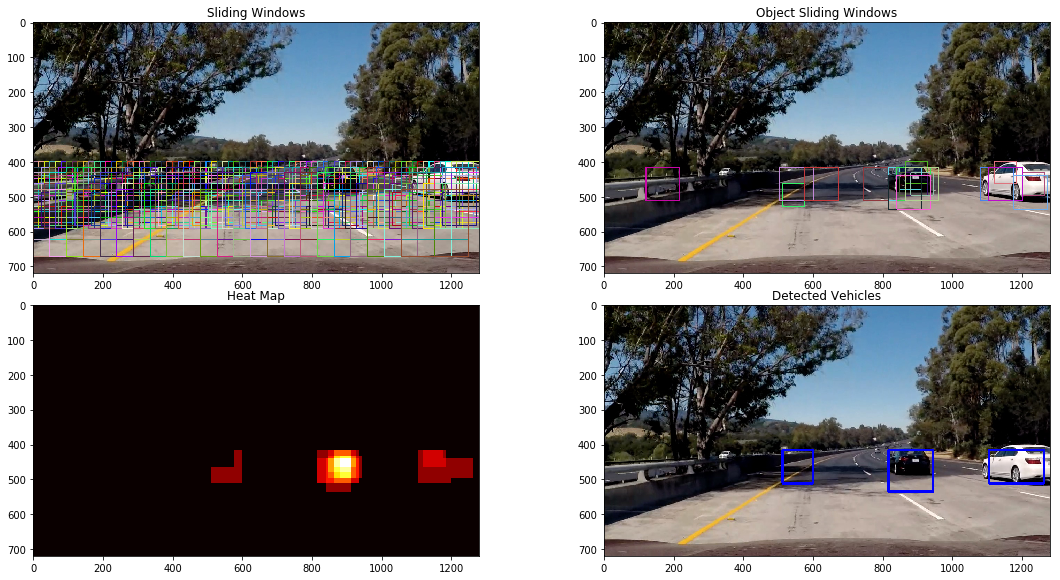

In [5]:
window_settings = [([400, 600], 1.0), ([416, 600], 1.5), ([432, 600], 2.0), ([432, 700], 3.0)]

img = mpimg.imread('./test_images/test5.jpg')

sliding_windows = find_all_cars(img, window_settings, show_all_windows=True)
sliding_windows = [item for sublist in sliding_windows for item in sublist]
img_sliding_windows = draw_boxes(img, sliding_windows, thick=2)

object_windows = find_all_cars(img, window_settings, show_all_windows=False)
object_windows = [item for sublist in object_windows for item in sublist]
img_object_windows = draw_boxes(img, object_windows, thick=2)

# create heat map
heat = np.zeros_like(img[:, :, 0].astype(np.float))
heatmap = add_heat(heat, object_windows)
heatmap = apply_threshold(heatmap, 1)
heatmap = np.clip(heatmap, 0, 255)
labels = label(heatmap)
# Draw bounding boxes on a copy of the image
img_labels = draw_labeled_boxes(img, labels)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
f.tight_layout()
ax1.imshow(img_sliding_windows)
ax1.set_title('Sliding Windows', fontsize=12)
ax2.imshow(img_object_windows)
ax2.set_title('Object Sliding Windows', fontsize=12)

ax3.imshow(heatmap, cmap='hot')
ax3.set_title('Heat Map', fontsize=12)
ax4.imshow(img_labels)
ax4.set_title('Detected Vehicles', fontsize=12)

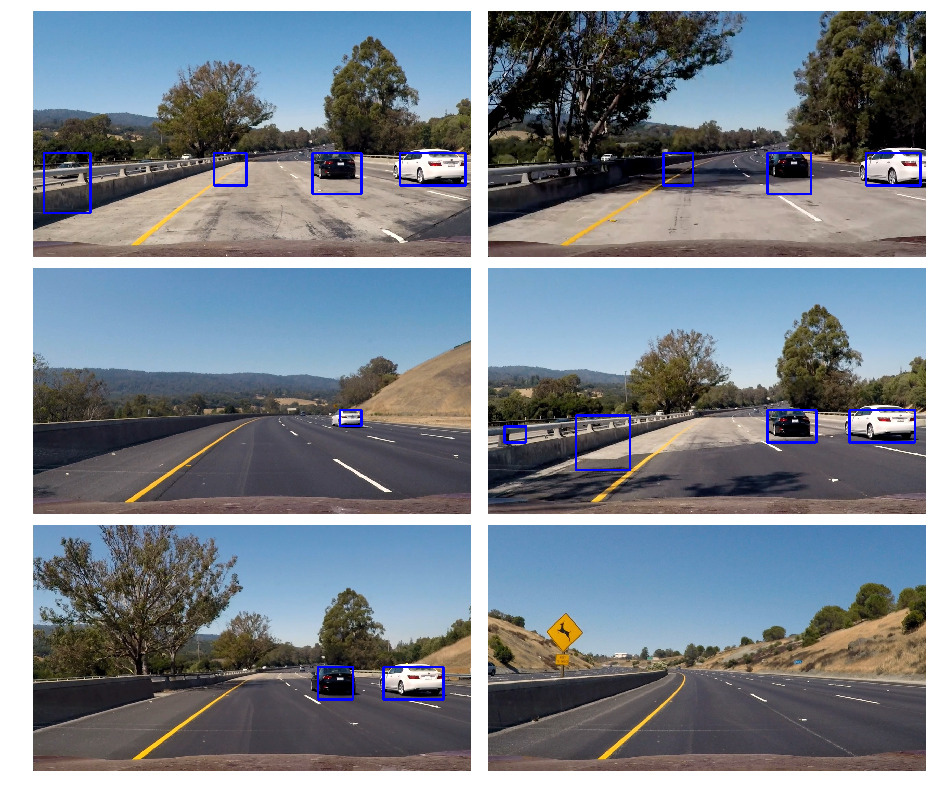

In [6]:
# Detect cars on all the test images
imgs_path = glob('./test_images/test*.jpg')
img_labels = []
for img_path in imgs_path:
    img = mpimg.imread(img_path)
    object_windows = find_all_cars(img, window_settings, show_all_windows=False)
    object_windows = [item for sublist in object_windows for item in sublist]
    # create heat map
    heat = np.zeros_like(img[:, :, 0].astype(np.float))
    heatmap = add_heat(heat, object_windows)
    heatmap = apply_threshold(heatmap, 1)
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    # Draw bounding boxes on a copy of the image
    img_labels.append(draw_labeled_boxes(img, labels))
    
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .04, wspace=.04)
axs = axs.ravel()

for i, img_label in enumerate(img_labels):
    axs[i].imshow(img_label)
    axs[i].axis('off')

### Process pipeline

In [7]:
object_windows_list = []
def process_pipeline(img):   
    all_img = np.zeros((360, 960, 3), np.uint8)
    
    object_windows = find_all_cars(img, window_settings, show_all_windows=False)
    object_windows = [item for sublist in object_windows for item in sublist]
    img_object_windows = draw_boxes(img, object_windows, thick=2)
    
    # record last detection;
    object_windows_list.append(object_windows)
    if len(object_windows_list) > 20:
        object_windows_list.pop(0)  # pop the oldest windows

    # create heat map
    heat = np.zeros_like(img[:, :, 0].astype(np.float))
    # add all the detected object windows
    for windows in object_windows_list:
        heat = add_heat(heat, windows) 
    heat = apply_threshold(heat, 1+int(len(object_windows_list)*1.5))
#     heat = apply_threshold(heat, 30)
    heatmap = np.clip(heat, 0, 255)
    if np.max(heatmap) > 0.0:
        factor = 255.0 / np.max(heatmap)
        heatmap *= factor      
    labels = label(heatmap)
    # Draw bounding boxes on a copy of the image
    img_labels = draw_labeled_boxes(img, labels)
    
    # combine images together
    all_img[0:360, 0:640] = cv2.resize(img_labels, (640, 360))
    all_img[0:180, 640:960] = cv2.resize(img_object_windows, (320, 180))
    all_img[180:360, 640:960] = cv2.resize(np.dstack((np.zeros_like(heatmap), np.zeros_like(heatmap), heatmap)),(320, 180))

    return all_img

In [9]:
object_windows_list = []
out_video = 'test_video_result.mp4'
clip1 = VideoFileClip("test_video.mp4")
out_clip = clip1.fl_image(process_pipeline)
%time out_clip.write_videofile(out_video, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|█████████▋| 38/39 [00:28<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

CPU times: user 1min 33s, sys: 2.21 s, total: 1min 35s
Wall time: 28.7 s


In [10]:
object_windows_list = []
out_video = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_pipeline)
%time out_clip.write_videofile(out_video, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [15:33<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 50min 53s, sys: 1min 10s, total: 52min 4s
Wall time: 15min 34s
